In [1]:
!pip install segmentation-models-pytorch -q

In [3]:
import kagglehub

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

from sklearn.cluster import KMeans

from torch.utils.data import Dataset, DataLoader
from torchvision import utils, datasets
from torchvision.transforms import v2


from PIL import Image

from pathlib import Path
from tqdm import tqdm
from typing import Optional, Sequence, Tuple, Any

device = "cuda" if torch.cuda.is_available() else "cpu"

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according 

In [3]:
# Download latest version
path = kagglehub.dataset_download("trainingdatapro/roads-segmentation-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/roads-segmentation-dataset


## Dataset

The segmentation mask contains color of various ranges. It was expected to contain color corresponding to only 30 classes. However, that doesn't seem to be the case.

To carry out segmentation, we need to create colors corresponding to those 30 classes only. For this, may be we can proceed by using K-means clustering to cluster colors around 30 colors representing the classes.

In [4]:
class BaseDataset(Dataset):
    """
    Base dataset class that processes data and targets through optional transforms.
    """
    def __init__(
        self,
        data,
        targets = None,
        transform = None,
        target_transform = None
    ) -> None:
        if targets is not None and len(data) != len(targets):
            raise ValueError("Data and Targets must be of equal length.")

        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, idx) -> Tuple[Any, Any]:
        datum, target = self.data[idx], self.targets[idx]

        if self.transform is not None:
            datum = self.transform(datum)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return datum, target

class DataModule:
    def __init__(self, batch_size, num_workers, on_gpu, shuffle):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.on_gpu = on_gpu
        self.shuffle = shuffle

    def prepare_data(self, *args, **kwargs) -> None:
        pass

    def setup(self, stage: Optional[str] = None) -> None:
        pass

    def train_dataloader(self):
        return DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            shuffle = self.shuffle,
            num_workers = self.num_workers,
            pin_memory = self.on_gpu
        )

    def val_dataloader(self):
        return DataLoader(
            dataset = self.val_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = self.num_workers,
            pin_memory = self.on_gpu
        )

    def test_dataloader(self):
        return DataLoader(
            dataset = self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = self.num_workers,
            pin_memory = self.on_gpu
        )        

def split_dataset(
    base_dataset: BaseDataset,
    fraction: float,
    seed: int
) -> Tuple[BaseDataset, BaseDataset]:
    first_split_size = int(len(base_dataset) * fraction)
    second_split_size = len(base_dataset) - first_split_size

    return torch.utils.data.random_split(
        dataset = base_dataset,
        lengths = [first_split_size, second_split_size],
        generator = torch.Generator().manual_seed(seed)
    )

In [5]:
class Road(DataModule):
    def __init__(self, mapping, resize, batch_size = 32, num_workers = 2, on_gpu = True, shuffle = True):
        super().__init__(batch_size, num_workers, on_gpu, shuffle)
        self.mapping = mapping
        self.resize = resize
        self.num_classes = 30
        transforms = v2.Compose([
            v2.Resize(self.resize),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.train_transforms = transforms
        self.test_transforms = transforms

    def prepare_data(self):
        self.data_dir = Path("/kaggle/input/roads-segmentation-dataset")
        if not self.data_dir.exists():
            _ = kagglehub.dataset_download("trainingdatapro/roads-segmentation-dataset")
        
            

    def setup(self):
        def _load_dataset(transform, target_transform):
            images, labels = self._load_images_and_labels()
            return BaseDataset(images, labels, transform, target_transform)

        target_transform = v2.Compose([
            v2.Resize(self.resize),
            v2.ToImage(),
            MapColor(self.mapping),
            # v2.ToDtype(torch.float32, scale=True),
        ])

        train_val_dataset = _load_dataset(self.train_transforms, target_transform)
        self.train_dataset, self.val_dataset = split_dataset(train_val_dataset, fraction=0.8, seed=41)
        self.val_dataset, self.test_dataset = split_dataset(self.val_dataset, fraction=0.5, seed=41)
        # self.test_dataset = _load_dataset("val", self.test_transforms, target_transform)

    def _load_images_and_labels(self):
        image_files = (self.data_dir / "images").glob("*.png")
        label_files = (self.data_dir / "masks").glob("*.png")

        images = [Image.open(file).convert("RGB") for file in image_files]
        labels = [Image.open(file).convert("RGB") for file in label_files]

        return images, labels

class MapColor(object):
    def __init__(self, color_to_idx: dict):
        self.color_to_idx = color_to_idx

    def __call__(self, img: Image): 
        width, height = img.shape[1:] #CHW format
        mapped_img = torch.full((width, height), fill_value=-1, dtype=torch.int32)
    
        for src, dst in color_to_idx.items():
            src = torch.tensor(src)
            idx = torch.where(torch.all(img.permute(1, 2, 0) == src, axis=-1))
            mapped_img[idx] = dst

        # print(mapped_img.shape)
    
        return mapped_img

def map_color(img, color_to_idx):
    image_torch = torch.tensor(img)
    width, height = image_torch.shape[:2]
    mapped_img = torch.full((width, height), fill_value=-1, dtype=torch.int32)
    
    for src, dst in color_to_idx.items():
        src = torch.tensor(src)
        idx = torch.where(torch.all(image_torch == src, axis=-1))
        mapped_img[idx] = dst

    print(mapped_img.shape)

    return mapped_img

class RoadStem:
    def __init__(self):
        super().__init__()

        self.pil_transforms = v2.Compose

In [6]:
# by using the information provided in the XML file

color_to_idx = {
    (184, 61, 245): 0, # background: #b83df5
    (255, 53, 94): 1, # road_sign: #ff355e
    (255, 204, 51): 2, # car: #ffcc33
    (221, 255, 51): 3, # marking: #ddff33
    (61, 61, 245): 4 # road_surface: #3d3df5
}

In [7]:
data_module = Road(color_to_idx, (512, 1024), batch_size=4)
data_module.prepare_data()
data_module.setup()

In [48]:
len(data_module.train_dataset), len(data_module.val_dataset), len(data_module.test_dataset)

(24, 3, 4)

In [8]:
train_dataloader, val_dataloader, test_dataloader = data_module.train_dataloader(), data_module.val_dataloader(), data_module.test_dataloader()

In [9]:
X, y = next(iter(train_dataloader))

In [10]:
masks = list((Path(path) / "masks").glob("*"))

In [22]:
target_transform = v2.Compose([
    v2.Resize((512, 1024)),
    v2.ToImage(),
    MapColor(color_to_idx),
            # v2.ToDtype(torch.float32, scale=True),
])
transform = v2.Compose([
    v2.Resize((512, 1024)),
    v2.ToImage(),
    # MapColor(color_to_idx),
            # v2.ToDtype(torch.float32, scale=True),
])
mask_imgs = [transform(Image.open(mask).convert("RGB")) for mask in masks[0:5]]
mapped_imgs = [target_transform(img) for img in mask_imgs]

In [47]:
np.array(Image.open(masks[0])).shape

(720, 1280, 4)

In [23]:
np.array(mask_imgs[0]).shape, mapped_imgs[0].shape

((3, 512, 1024), torch.Size([512, 1024]))

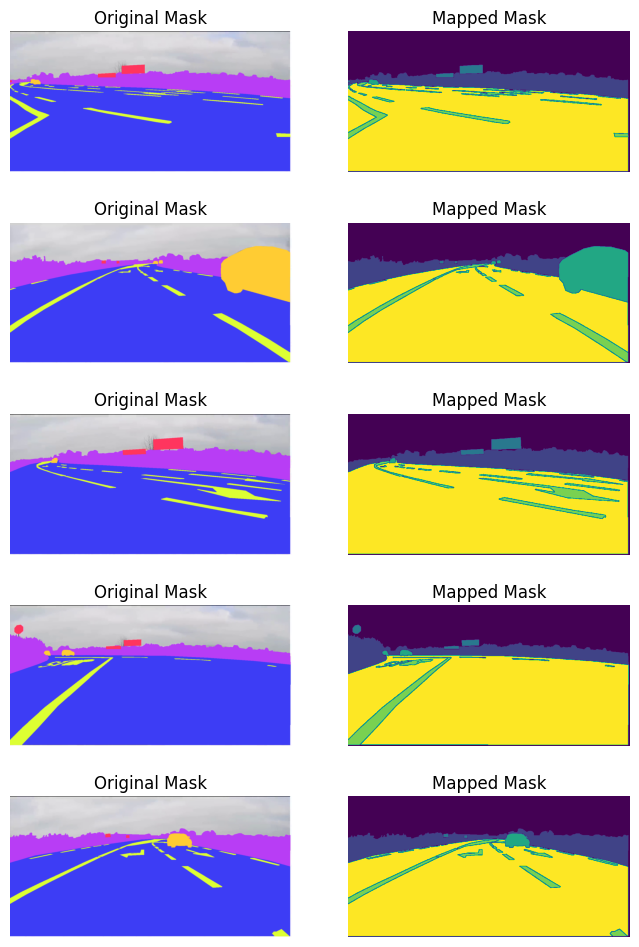

In [26]:
fig, axs = plt.subplots(5, 2, figsize=(8, 12))

for i in range(5):
    axs[i][0].imshow(mask_imgs[i].permute(1, 2, 0))
    axs[i][0].axis("off")
    axs[i][0].set_title("Original Mask")
    axs[i][1].imshow(mapped_imgs[i])
    axs[i][1].axis("off")
    axs[i][1].set_title("Mapped Mask")
    
plt.savefig("mask_map.png")

## U-Net Architecture

The UNet architecture is implemented below. Some notes:

1. Requires `BCHW` format.
2. To double the spatial size of the input, a stride of 2 with padding of 0, needed to be used in `nn.ConvTranspose2d` and `nn.MaxPool2d`. However, the input shape needs to be a $2^n$, where $n >= 4$.
3. The output shape is different than input shape because no padding is used.

Training performed worse without `nn.BatchNorm2d`.

In [27]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, padding):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )

  def forward(self, x):
    return self.double_conv(x)

class Down(nn.Module):
  def __init__(self, in_channels, out_channels, padding):
    super().__init__()
    self.down = nn.Sequential(
        nn.MaxPool2d(kernel_size=(2, 2)),
        DoubleConv(in_channels, out_channels, padding=padding)
    )

  def forward(self, x):
    return self.down(x)

class Up(nn.Module):
  def __init__(self, in_channels, out_channels, padding):
    super().__init__()
    self.padding = 0
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=(2, 2), stride=2)
    self.double_conv = DoubleConv(in_channels, out_channels, padding)

  def forward(self, x1, x2):
    if self.padding == 0:
      x1 = self.up(x1, output_size=(x1.shape[0], x1.shape[1], x1.shape[2] * 2, x1.shape[3] * 2))
      x2 = v2.CenterCrop((x1.shape[2], x1.shape[3]))(x2)

    x = torch.cat((x2, x1), dim=1)
    return self.double_conv(x)

class Out(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.out = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
    )

  def forward(self, x):
    return self.out(x)

class UNet(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, padding: int):
    super().__init__()
    self.inp = DoubleConv(in_channels, out_channels=64, padding=padding)
    self.down1 = Down(in_channels=64, out_channels=128, padding=padding)
    self.down2 = Down(in_channels=128, out_channels=256, padding=padding)
    self.down3 = Down(in_channels=256, out_channels=512, padding=padding)
    self.down4 = Down(in_channels=512, out_channels=1024, padding=padding)
    self.up1 = Up(in_channels=1024, out_channels=512, padding=padding)
    self.up2 = Up(in_channels=512, out_channels=256, padding=padding)
    self.up3 = Up(in_channels=256, out_channels=128, padding=padding)
    self.up4 = Up(in_channels=128, out_channels=64, padding=padding)
    self.out = Out(in_channels=64, out_channels=out_channels)

  def forward(self, x):
    x = self.inp(x)
    x1 = self.down1(x)
    x2 = self.down2(x1)
    x3 = self.down3(x2)
    x4 = self.down4(x3)

    x5 = self.up1(x4, x3)
    x6 = self.up2(x5, x2)
    x7 = self.up3(x6, x1)
    x8 = self.up4(x7, x)

    return self.out(x8)

## Training

In [28]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [29]:
def training_step(model, dataloader, criterion, optimizer, device):
    model.train()

    train_loss = 0.
    train_iou = 0.

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)

        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        probs = logits.softmax(dim=1)
        preds = probs.argmax(dim=1)

        # print(preds.shape)

        tp, fp, fn, tn = smp.metrics.get_stats(
            output=preds.detach().cpu().long(),
            target=y.cpu(),
            mode="multiclass",
            ignore_index=-1,
            num_classes=5
        )

        # print(tp, fp, fn, tn)

        train_loss += loss.item()
        train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        # print(loss)

    return train_loss / len(dataloader), train_iou / len(dataloader)
        

In [30]:
def validation_step(model, dataloader, criterion, device):
    model.eval()

    val_loss = 0.
    val_iou = 0.

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)

            logits = model(X)
            loss = criterion(logits, y)

            probs = logits.softmax(dim=1)
            preds = probs.argmax(dim=1)

            tp, fp, fn, tn = smp.metrics.get_stats(
                output=preds.detach().cpu().long(),
                target=y.cpu(),
                mode="multiclass",
                ignore_index=-1,
                num_classes=5
            )

            val_loss += loss.item()
            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

    return val_loss / len(dataloader), val_iou / len(dataloader)

In [31]:
def train(
    model, 
    train_dataloader, 
    val_dataloader, 
    criterion,
    optimizer, 
    early_stopping, 
    epochs, 
    device
):
    results = {
        "train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []
    }

    progress_bar = tqdm(total=epochs)

    for epoch in range(epochs):
        train_loss, train_iou = training_step(
            model, 
            train_dataloader, 
            criterion, 
            optimizer, 
            device
        )

        val_loss, val_iou = validation_step(
            model,
            val_dataloader,
            criterion,
            device
        )

        progress_bar.set_description(
            f"train loss: {train_loss} | "
            f"train iou: {train_iou} | "
            f"val loss: {val_loss} | "
            f"val iou: {val_iou}"
        )
        progress_bar.update(1)

        # break

        early_stopping(val_loss, model)
        if early_stopping.early_stop == True:
            print("Stopped early...")
            break

        results["train_loss"].append(train_loss)
        results["train_iou"].append(train_iou)
        results["val_loss"].append(val_loss)
        results["val_iou"].append(val_iou)

    return results

In [32]:
NUM_CLASSES = 5
EPOCHS = 50
SEED = 41

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

model = UNet(in_channels=3, out_channels=NUM_CLASSES, padding=1)
model = model.to(device)
criterion = smp.losses.DiceLoss(mode="multiclass", classes=5, ignore_index=-1)
# criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

early_stopping = EarlyStopping(patience=5, delta=0.)

In [33]:
results = train(
    model, 
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    early_stopping, 
    EPOCHS,
    device
)

train loss: 0.3039987583955129 | train iou: 0.8821136355400085 | val loss: 0.3875386118888855 | val iou: 0.8785552978515625:  34%|███▍      | 17/50 [04:42<09:07, 16.60s/it]  

Stopped early...


In [34]:
def loss_and_metric_plot(results):
    train_losses = results["train_loss"]
    val_losses = results["val_loss"]

    train_ious = results["train_iou"]
    val_ious = results["val_iou"]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    axs[0].plot(train_losses, label="training")
    axs[0].plot(val_losses, label="validation")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Dice Loss")
    axs[0].legend()

    axs[1].plot(train_ious, label="training")
    axs[1].plot(val_ious, label="validation")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Score")
    axs[1].set_title("IOU")
    axs[1].legend()

    fig.show()

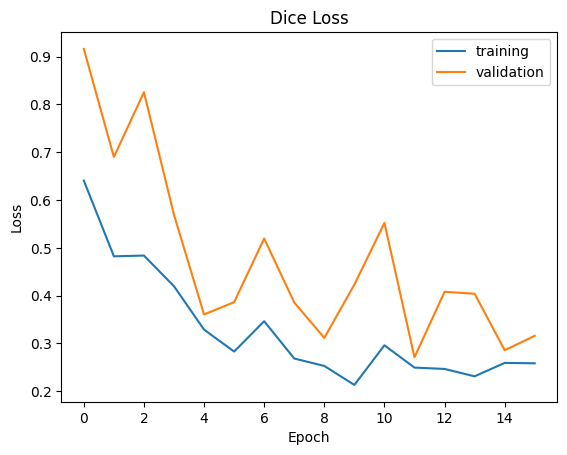

<Figure size 640x480 with 0 Axes>

In [36]:
train_losses = results["train_loss"]
val_losses = results["val_loss"]

plt.plot(train_losses, label="training")
plt.plot(val_losses, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Dice Loss")
plt.legend()
plt.show()
plt.savefig("diceloss.png")

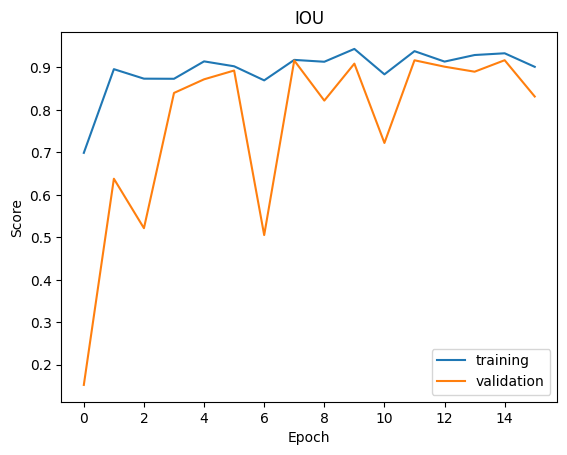

<Figure size 640x480 with 0 Axes>

In [38]:
train_iou = results["train_iou"]
val_iou = results["val_iou"]

plt.plot(train_iou, label="training")
plt.plot(val_iou, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("IOU")
plt.legend()
plt.show()
plt.savefig("iou.png")

In [ ]:
loss_and_metric_plot(results)
plt.savefig("segmentation_loss_and_metric.png")

## Inference

In [5]:
def predict(test_dataloader, best_model: str, device):
    model = UNet(in_channels=3, out_channels=5, padding=1)
    model.load_state_dict(torch.load(best_model))
    model.to(device)
    model.eval()

    test_inputs = []
    test_targets = []
    test_preds = []

    with torch.inference_mode():
        for X, y in tqdm(test_dataloader):
            X = X.to(device, dtype=torch.float32)

            logits = model(X)
            probs = logits.softmax(dim=1)
            preds = probs.argmax(dim=1)

            test_inputs.append(X.detach().cpu())
            test_targets.append(y.detach().cpu())
            test_preds.append(preds.detach().cpu())

    return torch.cat(test_inputs), torch.cat(test_targets), torch.cat(test_preds)

In [40]:
X, y = next(iter(test_dataloader))
X, y = X.to(device), y.to(device)

In [41]:
test_inputs, test_targets, test_preds = predict(test_dataloader, "/kaggle/working/best_model.pth", device)

100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


In [42]:
tp, fp, fn, tn = smp.metrics.get_stats(
    output=test_preds.long(),
    target=test_targets.long(),
    mode="multiclass",
    ignore_index=-1,
    num_classes=5
)

In [43]:
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
print(f"IOU = {iou:.4f}")

IOU = 0.9359


In [44]:
idx_to_color = {
    0: (184, 61, 245),
    1: (255, 53, 94),
    2: (255, 204, 51),
    3: (221, 255, 51),
    4: (61,61, 245)
}

In [45]:
def map_id_to_color(pred_mask, target_mask, idx_to_color):

    ignore = target_mask == -1
    mask = torch.where(ignore, -1, pred_mask)

    width, height = mask.shape
    mapped_img = torch.zeros((width, height, 3), dtype=torch.uint8)
    for src, dst in idx_to_color.items():
        dst = torch.tensor(dst, dtype=torch.uint8)
        # src = torch.tensor(src)
        idx = torch.where(torch.all(mask[:, :, None] == src, dim=-1))
        mapped_img[idx] = dst

    return mapped_img

def map_target_mask_to_color(mask, idx_to_color):
    width, height = mask.shape
    mapped_img = torch.zeros((width, height, 3), dtype=torch.uint8)
    for src, dst in idx_to_color.items():
        dst = torch.tensor(dst, dtype=torch.uint8)
        # src = torch.tensor(src)
        idx = torch.where(torch.all(mask[:, :, None] == src, dim=-1))
        mapped_img[idx] = dst

    return mapped_img

In [6]:
fig, axs = plt.subplots(nrows=len(test_targets), ncols=3, figsize=(10, 8))

for i in range(len(test_targets)):
    target, pred = map_target_mask_to_color(test_targets[i], idx_to_color), map_id_to_color(test_preds[i], test_targets[i], idx_to_color)

    axs[i][0].imshow(test_inputs[i].permute(1, 2, 0))
    axs[i][0].set_title("Input Image")
    axs[i][0].axis("off")
    
    axs[i][1].imshow(target)
    axs[i][1].set_title("Original Mask")
    axs[i][1].axis("off")

    axs[i][2].imshow(pred)
    axs[i][2].set_title("Predicted Mask")
    axs[i][2].axis("off")

fig.tight_layout()
fig.show()
plt.savefig("Predictions on Test set")

NameError: name 'test_targets' is not defined